In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from src.manager import DbManager
from src.utils import reduce_mem_usage

dbm = DbManager('../vast.db')

In [3]:
dbm.connect()

In [16]:
dbm.close()

In [11]:
df = dbm.sql_to_df("SELECT avg_ts.machine_id, avg_ts.inet_down_avg, avg_ts.inet_up_avg, cost_snp.inet_down_cost, cost_snp.inet_up_cost FROM avg_ts INNER JOIN cost_snp ON avg_ts.machine_id = cost_snp.machine_id").drop_duplicates(subset='machine_id', keep='last')
df

,machine_id,inet_down_avg,inet_up_avg,inet_down_cost,inet_up_cost
84,4869,341,322,10,30
1496,13618,882,474,0,0
1577,13756,354,34,2,3
1767,14054,159,368,2,3
1814,14135,76,23,2,3
...,...,...,...,...,...
396931,22952,0,0,0,0
396932,22953,0,0,0,1
396933,22954,0,0,2,3
396934,22956,0,0,32,32


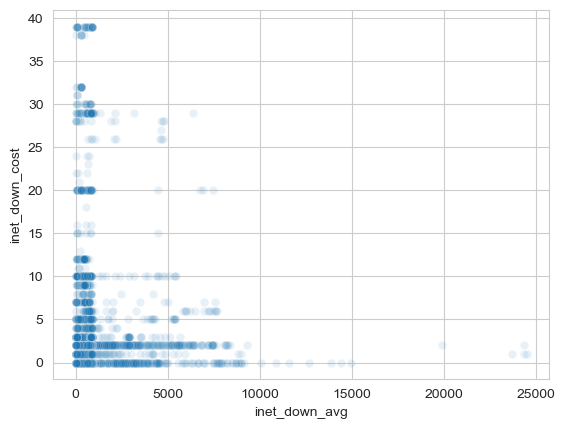

In [14]:
import seaborn as sns

sns.scatterplot(df, x='inet_down_avg', y='inet_down_cost', alpha=0.1);

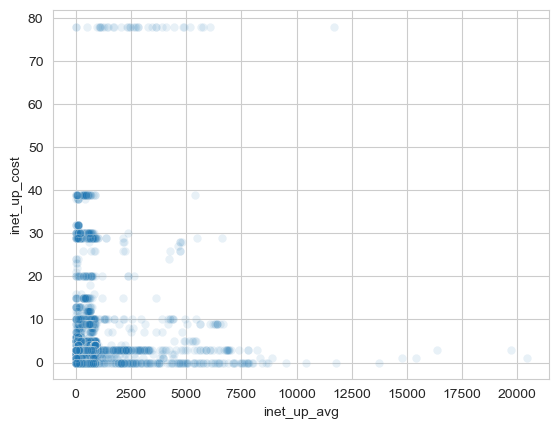

In [15]:
sns.scatterplot(df, x='inet_up_avg', y='inet_up_cost', alpha=0.1);

In [167]:
avg = dbm.table_to_df('avg_ts')
avg.drop_duplicates(subset='machine_id', keep='last', inplace=True)
avg.set_index('machine_id', inplace=True)


In [168]:
hw = dbm.table_to_df('hardware_snp').set_index('machine_id')


In [169]:
eod = dbm.table_to_df('eod_snp').set_index('machine_id')


In [170]:
cost = dbm.table_to_df('cost_snp').set_index('machine_id')


In [171]:
rent = dbm.table_to_df('rent_snp').set_index('machine_id')

In [172]:
dbm.close()

In [173]:
df1 = pd.merge(eod, hw, left_index=True, right_index=True, how='inner')
df2 = pd.merge(cost, rent, left_index=True, right_index=True, how='inner')
# df2 = pd.merge(df1, avg, left_index=True, right_index=True, how='inner')

In [174]:
df = pd.merge(df1, df2, on='machine_id', how='inner')
df = pd.merge(df, avg, on='machine_id', how='inner')

In [175]:
df

,cuda_max_good,driver_version,direct_port_count,min_chunk,verification,end_date,country,public_ipaddr,static_ip,isp,...,pcie_bw_std,dlperf_avg,dlperf_std,inet_down_avg,inet_down_std,inet_up_avg,inet_up_std,score_avg,score_std,timestamp
machine_id,,,,,,,,,,,,,,,,,,,,,
63,12.2,535.104.05,1000,1,1,1719792000,US,23.245.210.159,0,Atlantic Broadband,...,0.0,9,0.00,386,5.85,47,0.00,16,0.49,1714694400
162,12.4,550.76,1000,4,1,1714953600,US,23.245.210.159,1,Atlantic Broadband,...,0.0,33,0.00,428,24.73,49,0.48,25,0.75,1714694400
274,12.0,525.60.11,1000,1,1,1698796800,UA,194.44.114.10,1,,...,0.5,30,0.00,451,0.00,370,0.00,51,1.24,1698883200
275,12.0,525.60.11,1000,1,2,1709164800,UA,194.44.114.10,1,,...,0.0,28,0.15,513,0.00,446,0.00,68,1.76,1708300800
283,12.0,525.60.11,1000,2,1,1698796800,UA,194.44.114.10,1,,...,0.0,22,0.68,444,0.00,398,0.00,48,2.22,1698883200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22952,12.2,535.161.08,1000,1,0,1717372800,CZ,90.183.51.3,1,O2 Czech Republic,...,0.0,555,10.25,0,0.00,0,0.00,6,0.64,1714694400
22953,12.4,550.54.15,0,1,0,1717200000,,160.202.129.99,1,,...,0.0,288,689.93,0,0.00,0,0.00,2,3.77,1714694400
22954,12.2,535.171.04,0,1,0,1715472000,PL,188.33.248.125,0,Play,...,0.0,77,13.41,0,0.00,0,0.00,12,2.12,1714694400


In [176]:
# preprocess
df.dph_base = (df.dph_base / df.num_gpus)

In [177]:
countries = df.query("gpu_name == 'RTX 4090'").groupby('country')['country'].count().sort_values(ascending=False)
countries[countries > 30]

country
US    771
CA    242
CN    172
KR    163
GB    108
IS    104
NO     90
JP     88
RU     73
       72
TW     68
CZ     53
ES     47
PL     38
DE     37
FR     35
RO     33
NL     33
BG     31
Name: country, dtype: int64

In [178]:
cnt = df.query("verification == 1 & num_gpus_rented > 0 & hosting_type == 0 & gpu_name == 'RTX 4090'").groupby('country')['country'].count().sort_values(ascending=False)
cnt[cnt > 10]

country
US    225
CA     62
JP     48
TW     40
KR     29
NO     27
GB     27
RU     19
RO     19
ES     18
TR     16
PL     16
VN     14
FI     14
Name: country, dtype: int64

In [179]:
mask = df.country.isin(cnt[cnt > 10].index)
mask.sum()

5628

In [181]:
df[mask].query("verification == 1 & num_gpus_rented > 0 & hosting_type == 0 & gpu_name == 'RTX 4090'").groupby('country')[['dph_base', 'inet_down_avg', 'inet_up_avg', 'disk_bw_avg', 'storage_cost', 'inet_up_cost', 'inet_down_cost', 'credit_discount_max']].mean().sort_values(by='dph_base', ascending=False).round().astype(int)

,dph_base,inet_down_avg,inet_up_avg,disk_bw_avg,storage_cost,inet_up_cost,inet_down_cost,credit_discount_max
country,,,,,,,,
JP,583,2377,1499,3706,217,7,7,38
ES,579,4880,4240,4875,171,8,5,29
FI,532,663,514,2854,326,5,3,107
US,523,1683,1224,4232,202,5,3,78
RO,511,510,481,4315,176,6,4,89
GB,489,963,536,3353,287,3,2,52
NO,482,604,537,3652,206,6,6,89
CA,448,784,721,3154,303,8,7,73
VN,438,798,781,6002,150,0,0,0


In [186]:

# machine_id = 12113
# machine_id = 8506
# ts = rel_df.loc[machine_id, 'timestamp']
# vals = rel_df.loc[machine_id, 'reliability']
# if ts.shape:
#     ts = ts.values
#     vals = vals.values
# df.loc[ts, machine_id] = vals


In [187]:
%%time
for machine_id in machine_ids:
    try:
        ts = rel_df.loc[machine_id, 'timestamp']
        vals = rel_df.loc[machine_id, 'reliability']
        if ts.shape:
            ts = ts.values
            vals = vals.values
        df.loc[ts, machine_id] = vals
    except Exception as e:
        print(machine_id, e)

CPU times: total: 1.62 s
Wall time: 1.62 s


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26378 entries, 1691935057 to 1694165858
Columns: 1957 entries, (162,) to (12852,)
dtypes: UInt16(1957)
memory usage: 148.9 MB


In [204]:
# by timestamp
def explode_table(id_col, col, table, conn):    
    ts_idx = pd.read_sql('SELECT timestamp FROM timestamp_tbl', conn).timestamp.values
    raw_df = pd.read_sql(f'SELECT timestamp, {id_col}, {col} FROM {table}', conn).set_index(id_col)
    raw_df.sort_index(inplace=True)
    raw_df = reduce_mem_usage(raw_df)
    raw_df[col] = raw_df[col].convert_dtypes()
    ids = raw_df.index.unique()
    
    df = pd.DataFrame(columns=[ids], index=ts_idx, dtype=raw_df[col].dtype)    
    
    for idx in ids:
        ts = raw_df.loc[idx, 'timestamp']
        vals = raw_df.loc[idx, col]
        if ts.shape:
            ts = ts.values
            vals = vals.values
        df.loc[ts, idx] = vals
        
    df.fillna(method='ffill', inplace=True)
    return df

In [205]:
df = explode_table('machine_id', 'online', 'online_ts', conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26975 entries, 1691935057 to 1694165858
Columns: 1957 entries, (162,) to (12852,)
dtypes: Int8(1957)
memory usage: 101.9 MB


In [201]:
df.fillna(0, inplace=True)
df.astype(np.uint8).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26975 entries, 1691935057 to 1694165858
Columns: 1957 entries, (162,) to (12852,)
dtypes: uint8(1957)
memory usage: 51.6 MB


In [ ]:
ts_rent = pd.read_sql('SELECT DISTINCT timestamp FROM rent_ts', conn).timestamp
ts_rent.shape

In [ ]:
ts_rel = pd.read_sql('SELECT DISTINCT timestamp FROM reliability_ts', conn).timestamp
ts_rel.shape

In [ ]:
ts_rent[~ts_rent.isin(ts_rel)]

In [ ]:
df = explode_table('id', 'rented', 'rent_ts', conn)
df.info()

In [ ]:
df[274].dropna().eq(0).sum()

In [ ]:
for col in df:
    if df[col].eq(0).any():
        print(col)

In [ ]:
arr = df[12760].fillna(0).values

In [ ]:
%timeit non_zero_idx = np.nonzero(arr); _ = arr[non_zero_idx]

In [ ]:
%timeit _ = arr[non_zero_idx]

In [ ]:
from pandas.core.dtypes.common import is_integer_dtype, is_float_dtype

